In [43]:
import numpy as np
from numpy import diff
import pandas as pa
import pylab as pl
from scipy.signal import hilbert
from scipy import signal
%matplotlib inline
import matplotlib.pylab as plt
import sqlite3

In [2]:
ActualWeight = pa.read_excel("Seq2Seq/Actual_Weight_Urine_Stool_1736_1745.xlsx")
ActualWeight['Total Weight (g)'] = ActualWeight.iloc[:, 1:].sum(axis = 1)
ActualWeight

,ID,Actual Urine Weight (g),Actual Stool Weight (g),Total Weight (g)
0,1736,196.98,191.21,388.19
1,1737,199.95,208.36,408.31
2,1738,196.98,356.79,553.77
3,1739,197.10,318.63,515.73
4,1740,200.00,254.93,454.93
5,1741,200.50,330.66,531.16
6,1742,200.79,374.66,575.45
7,1743,197.14,431.00,628.14
8,1744,198.93,492.33,691.26
9,1745,198.47,305.82,504.29


In [3]:
DATA_CAPTURE_ID = 1736

In [4]:
def GetSensor(use_i,sensor_i):
    sql_s = "SELECT timestamp_ms, value FROM data WHERE data_capture_id={} AND sensor_id={}".format(use_i,sensor_i)
    conn = sqlite3.connect('data/toilet.db')
    cursor = conn.execute(sql_s)
    time_measurements = []
    distance_measurements = []
    for row in cursor:
        time_measurements.append(row[0])
        distance_measurements.append(row[1])
    #endfor
    data_t = (time_measurements,distance_measurements)
    return data_t
#enddef

def cleanSensors(sensor1_t_l,sensor1_y_l,sensor2_t_l,sensor2_y_l):

    # get min / max of time-series
    #sensor1_t_l = data_d[1][0]
    #sensor2_t_l = data_d[2][0]
    #sensor1_y_l = data_d[1][1]
    #sensor2_y_l = data_d[2][1]
    min_t = min(min(sensor1_t_l),min(sensor2_t_l))
    max_t = max(max(sensor1_t_l),max(sensor2_t_l))

    # setup partitions
    step_t = 500
    min_floor_t = int(np.floor(min_t/step_t)*step_t)
    max_ceil_t = int(np.ceil(max_t/step_t)*step_t)
    
    step1_d = {}
    step2_d = {}
    for i in range(min_floor_t,max_ceil_t+step_t,step_t):
        step1_d[i] = []
        step2_d[i] = []
    #endfor

    # step through both and assign values to each partition
    for i in range(len(sensor1_t_l)):
        interval_t = int(np.floor(sensor1_t_l[i]/step_t)*step_t)
        step1_d[interval_t].append(sensor1_y_l[i])
    #endfor
    for i in range(len(sensor2_t_l)):
        interval_t = int(np.floor(sensor2_t_l[i]/step_t)*step_t)
        step2_d[interval_t].append(sensor2_y_l[i])
    #endfor

    # step through each partition and either take averages or set to nan
    clean1_d = {}
    for i in step1_d.keys():
        if(len(step1_d[i]) > 0):
            clean1_d[i] = np.mean(step1_d[i])
    #endfor
    clean1_sz = pa.Series(clean1_d)

    clean2_d = {}
    for i in step2_d.keys():
        if(len(step2_d[i]) > 0):
            clean2_d[i] = np.mean(step2_d[i])
    #endfor
    clean2_sz = pa.Series(clean2_d)
    
    return clean1_sz, clean2_sz

def GetTotalWeight(data_capture_id):
    data_d = {}
    data_d[2] = GetSensor(data_capture_id, 2) # seat scale
    data_d[3] = GetSensor(data_capture_id, 3) # foot scale
    
    #t0 = data_d[2][0][0]
    
    clean1_sz, clean2_sz = cleanSensors(data_d[2][0],data_d[2][1],data_d[3][0],data_d[3][1])
    seatScale_sz = clean1_sz/1000
    footScale_sz = clean2_sz/1000
    sumScale_sz = seatScale_sz  + footScale_sz
    #sumScaleFiltered_sz = pd.Series(signal.medfilt(sumScale_sz, 11))
        
    sumScale_sz.index = (sumScale_sz.index - sumScale_sz.index[0])/1000
    #x_ix = sumScale_sz.index
    return sumScale_sz

def GetRadarSum(data_capture_id):

    data_fn = 'data/data_frames/data_capture_{}/radar_data.txt'.format(data_capture_id)
    data_f = open(data_fn,'rt')
    line_s = data_f.read()
    data_l = eval(line_s)

    # save array of images
    t0_sz = pa.Series(data_l[0]['data'])
    data_d = {}
    for j in range(len(data_l)):
        t = data_l[j]['timestamp_ms']
        j_sz = pa.Series(data_l[j]['data'][0])
        data_d[t] = j_sz
    #endfor
    data_df = pa.DataFrame(data_d)
    
    area_d = {}
    floor_i = 50
    ceil_i = 200
    for i in data_df.columns:
        sq_sz = (data_df[i])**2
        area_d[i] = sum(sq_sz.iloc[floor_i:ceil_i])
    #endfor
    area_sz = pa.Series(area_d)
    area_sz = area_sz / 1e9
    area_sz = area_sz - area_sz.median()
    t0 = data_l[0]['timestamp_ms']
    area_sz.index = (area_sz.index-t0)/1000 #
    
    return area_sz

In [5]:
def frame(data, window_length, hop_length):
    num_samples = data.shape[0]
    num_frames = 1 + int(np.floor((num_samples - window_length) / hop_length))
    shape = (num_frames, window_length) + data.shape[1:]
    strides = (data.strides[0] * hop_length,) + data.strides
    return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)

In [63]:
def ApplyEnvelope(sz):
    analytic_signal = hilbert(sz)
    env_sz = pa.Series(np.abs(analytic_signal))
    env_sz.index = sz.index
    return env_sz

def GetValuesAboveThreshold(sz, threshold):
    return sz > threshold

def GetValuesBelowThreshold(sz, threshold):
    return sz < threshold

def ApplyMedianFilter(sz, window_size):
    filt_sz = pa.Series(signal.medfilt(sz, window_size))
    filt_sz.index = sz.index
    return filt_sz

def GetStartEndTimesOfBooleanSz(sz):
    ts = sz.index
    start_end_times = []
    
    i = 0
    while i < len(sz):
        if sz.values[i] == True:
            j = i
            while (j < len(sz)-1) and (sz.values[j+1] == True):
                j += 1
            start_end_times.append([ts[i], ts[j]])
            i = j + 1
        else:
            i += 1

    return start_end_times

def GetWeightChange(weight_sz, start_time, end_time):
    start_idx = (pa.Series(weight_sz.index) > start_time).idxmax() - 1
    end_idx = (pa.Series(weight_sz.index) > end_time).idxmax()
    #print("Weight at start time: {}".format(weight_sz.iloc[start_idx]))
    #print("Weight at end time: {}".format(weight_sz.iloc[end_idx]))
    return weight_sz.iloc[start_idx] - weight_sz.iloc[end_idx]

def GetWeightChangeMinMax(weight_sz, start_time, end_time):
    #start_idx = (pa.Series(weight_sz.index) > start_time).idxmax() - 1
    end_idx = (pa.Series(weight_sz.index) > end_time).idxmax()
    weight_sz_start_end = weight_sz[(weight_sz.index > start_time) & (weight_sz.index < end_time)]
    return max(weight_sz_start_end) - weight_sz.iloc[end_idx]

def RightExtendBooleanTrueValues(sz, extension_time):
    temp_sz = sz.copy()
    i = 1
    while i < len(temp_sz):
        if((temp_sz.values[i-1] == True) and (temp_sz.values[i] == False)):
            extension_end_time = temp_sz.index[i] + extension_time
            while (i < len(temp_sz)) and (temp_sz.index[i] < extension_end_time):
                temp_sz.values[i] = True
                i += 1
        i += 1
    return temp_sz

def LeftExtendBooleanTrueValues(sz, extension_time):
    temp_sz = sz.copy()
    i = len(temp_sz) - 2
    while i >= 0:
        if((temp_sz.values[i] == False) and (temp_sz.values[i+1] == True)):
            extension_end_time = temp_sz.index[i] - extension_time
            while (i >= 0) and (temp_sz.index[i] > extension_end_time):
                temp_sz.values[i] = True
                i -= 1
        i -= 1
    return temp_sz

In [64]:
def GetWeightFrequencySampling(DATA_CAPTURE_ID):
    time_ms, ts_weight_g = GetSensor(DATA_CAPTURE_ID,2) # seat scale
    ts_total_time_s = float((time_ms[len(time_ms) -1] - time_ms[0])/1000)
    ts_num_samples = len(time_ms)
    ts_frequency_sampling = float(ts_num_samples / ts_total_time_s)
    ts_weight_g_sz = pa.Series(ts_weight_g)
    return ts_weight_g_sz, ts_frequency_sampling

def GetWeightDerivative(ts_weight_g_sz):
    ts_weight_g_derivative = diff(ts_weight_g_sz.to_numpy())/diff(ts_weight_g_sz.index)
    ts_weight_g_derivative = np.append(ts_weight_g_derivative, 0)
    return ts_weight_g_derivative

def GetFilteredWeightEnergySZ(ts_weight_g_derivative, WINDOW_SECONDS, HOP_SECONDS, ts_frequency_sampling):
    ts_window_length = int(round(WINDOW_SECONDS * ts_frequency_sampling))
    ts_hop_length = int(round(HOP_SECONDS * ts_frequency_sampling))
    ts_weight_frames = frame(ts_weight_g_derivative, ts_window_length, ts_hop_length)
    ts_weight_energy = np.sum(ts_weight_frames*ts_weight_frames, 1)
    ts_weight_energy_sz = pa.Series(ts_weight_energy)
    ts_frame_n = ts_weight_frames.shape[0]
    ts_weight_energy_sz.index = np.array(range(ts_frame_n))*float(ts_window_length/ts_frequency_sampling)
    ts_weight_energy_filt_sz = ApplyMedianFilter(ts_weight_energy_sz, 5)
    return ts_weight_energy_filt_sz

def GetFilteredWeightSZ(ts_weight_g_sz, WINDOW_SECONDS, HOP_SECONDS, ts_frequency_sampling):
    ts_window_length = int(round(WINDOW_SECONDS * ts_frequency_sampling))
    ts_hop_length = int(round(HOP_SECONDS * ts_frequency_sampling))
    ts_weight_frames = frame(ts_weight_g_sz.to_numpy()/1000,ts_window_length,ts_hop_length)
    ts_weight_filt = np.median(ts_weight_frames, 1)
    ts_weight_filt_sz = pa.Series(ts_weight_filt)
    ts_frame_n = ts_weight_frames.shape[0]
    ts_weight_filt_sz.index = np.array(range(ts_frame_n))*float(ts_window_length/ts_frequency_sampling)
    return ts_weight_filt_sz
    
def GetWeightStable(ts_weight_energy_sz):
    ts_weight_energy_filt_sz = ApplyMedianFilter(ts_weight_energy_sz, 5)
    ts_weight_is_stable = GetValuesBelowThreshold(ts_weight_energy_filt_sz, 5e5)
    return ts_weight_is_stable

def GetWeightStartEndTimes(DATA_CAPTURE_ID, WINDOW_SECONDS, HOP_SECONDS):
    ts_weight_g_sz, ts_frequency_sampling = GetWeightFrequencySampling(DATA_CAPTURE_ID)
    ts_weight_g_derivative = GetWeightDerivative(ts_weight_g_sz)
    
    ts_weight_filt_sz = GetFilteredWeightSZ(ts_weight_g_sz, WINDOW_SECONDS, HOP_SECONDS, ts_frequency_sampling)
    ts_weight_above_3kg = GetValuesAboveThreshold(ts_weight_filt_sz, 3)
    
    ts_weight_energy_sz = GetFilteredWeightEnergySZ(ts_weight_g_derivative,
                                                    WINDOW_SECONDS, HOP_SECONDS, ts_frequency_sampling)
    ts_weight_is_stable = GetWeightStable(ts_weight_energy_sz)
    
    start_end_times = GetStartEndTimesOfBooleanSz(ts_weight_is_stable & ts_weight_above_3kg)
    return start_end_times

def GetPredictedTotalWeightLoss(DATA_CAPTURE_ID, start_end_times, filter_window_size):
    start_time = start_end_times[0][0]+1
    end_time = start_end_times[-1][1]-1
    
    total_weight_sz = GetTotalWeight(DATA_CAPTURE_ID)
    total_weight_filt_sz = ApplyMedianFilter(total_weight_sz, filter_window_size)
    
    print("User case {}".format(DATA_CAPTURE_ID))
    print("Estimated start time: {:.2f}".format(start_time))
    print("Estimated end time: {:.2f}".format(end_time))
    #total_weight_loss = GetWeightChange(total_weight_filt_sz, start_time, end_time)
    total_weight_loss = GetWeightChangeMinMax(total_weight_filt_sz, start_time, end_time)
    print("Estimated total weight loss: {:.3f} g".format(total_weight_loss*1000))
    return total_weight_loss
    

def PlotTotalWeightStartEndTimes(DATA_CAPTURE_ID, WINDOW_SECONDS, HOP_SECONDS, filter_window_size):
    start_end_times = GetWeightStartEndTimes(DATA_CAPTURE_ID, WINDOW_SECONDS, HOP_SECONDS)
    total_weight_loss = GetPredictedTotalWeightLoss(DATA_CAPTURE_ID, start_end_times, filter_window_size)
    actual_weight_loss = ActualWeight[ActualWeight.ID == DATA_CAPTURE_ID]['Total Weight (g)'].values[0]
    print("Actual total weight loss:{:.3f} g".format(actual_weight_loss))
    
    total_weight_sz = GetTotalWeight(DATA_CAPTURE_ID)
    total_weight_filt_sz = ApplyMedianFilter(total_weight_sz, 5)
    
    fig, ax = plt.subplots(2, 1, figsize = (10, 4))
    ax[0].plot(total_weight_sz)
    ax[1].plot(total_weight_filt_sz)
    
    ax[0].set_ylim(total_weight_sz.median()-0.5, total_weight_sz.median()+0.5)
    ax[1].set_ylim(total_weight_sz.median()-0.5, total_weight_sz.median()+0.5)
    
    for i in range(2):
        for start_end_time in start_end_times:
            ax[i].axvspan(start_end_time[0], start_end_time[1], alpha=0.5, color='orange')
    
    plt.show()

In [72]:
def GetDefecationWeightLoss(DATA_CAPTURE_ID, filter_window_size, threshold, extension_time):
    defecation_start_end_times = GetDefecationStartEndTimes(DATA_CAPTURE_ID, filter_window_size, threshold, extension_time)
    defecation_weight_loss = 0
    
    total_weight_sz = GetTotalWeight(DATA_CAPTURE_ID)
    total_weight_filt_sz = ApplyMedianFilter(total_weight_sz, filter_window_size)
    
    for start_end in defecation_start_end_times:
        weight_loss = GetWeightChange(total_weight_filt_sz, start_end[0], start_end[1])
        if weight_loss > 0:
            defecation_weight_loss += weight_loss
            #print("Between {} and {}, weight loss:{}\n".format(start_end[0], start_end[1], weight_loss))
    return defecation_weight_loss

def GetDefecationStartEndTimes(DATA_CAPTURE_ID, filter_window_size, threshold, extension_time):
    radar_sum_sz = GetRadarSum(DATA_CAPTURE_ID)
    radar_sum_env_sz = ApplyEnvelope(radar_sum_sz)
    radar_sum_env_filt_sz = ApplyMedianFilter(radar_sum_env_sz, filter_window_size)
    radar_sum_filt_sz = ApplyMedianFilter(radar_sum_sz, filter_window_size)
    radar_vals_above_threshold = GetValuesAboveThreshold(radar_sum_filt_sz, threshold)
    radar_vals_above_threshold = RightExtendBooleanTrueValues(radar_vals_above_threshold, extension_time)
    radar_vals_above_threshold = LeftExtendBooleanTrueValues(radar_vals_above_threshold, extension_time)
    defecation_start_end_times = GetStartEndTimesOfBooleanSz(radar_vals_above_threshold)
    
    return defecation_start_end_times

def PlotDefecationWeightRadar(DATA_CAPTURE_ID, filter_window_size, threshold, extension_time):
    start_end_times = GetDefecationStartEndTimes(DATA_CAPTURE_ID, filter_window_size, threshold, extension_time)
    
    total_weight_loss = GetDefecationWeightLoss(DATA_CAPTURE_ID, filter_window_size, threshold, extension_time)
    print("Predicted total: {}".format(total_weight_loss))
    if DATA_CAPTURE_ID in ActualWeight.ID:
        print("Actual    total: {}".format(ActualWeight[ActualWeight.ID == DATA_CAPTURE_ID].iloc[:, 2].values[0]/1000))
    
    radar_sum_sz = GetRadarSum(DATA_CAPTURE_ID)
    total_weight_sz = GetTotalWeight(DATA_CAPTURE_ID)
    total_weight_filt_sz = ApplyMedianFilter(total_weight_sz, 5)
    
    fig, ax = plt.subplots(3, 1, figsize = (10, 6))
    ax[0].plot(total_weight_sz)
    ax[1].plot(total_weight_filt_sz)
    ax[2].plot(radar_sum_sz)
    
    ax[0].set_ylim(total_weight_sz.median()-0.5, total_weight_sz.median()+0.5)
    ax[1].set_ylim(total_weight_sz.median()-0.5, total_weight_sz.median()+0.5)
    
    for i in range(3):
        for start_end_time in start_end_times:
            ax[i].axvspan(start_end_time[0], start_end_time[1], alpha=0.5, color='orange')
    
    plt.show()

User case 1736
Estimated start time: 78.86
Estimated end time: 185.46
Estimated total weight loss: 419.500 g
Actual total weight loss:388.190 g


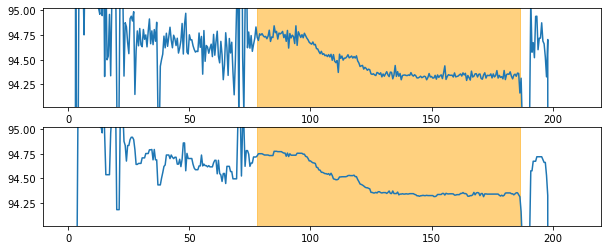

In [65]:
#GetPredictedTotalWeightLoss(DATA_CAPTURE_ID, start_end_times, 5)
DATA_CAPTURE_ID = 1736
PlotTotalWeightStartEndTimes(DATA_CAPTURE_ID, 2, 2, 5)

User case 1737
Estimated start time: 44.01
Estimated end time: 136.22
Estimated total weight loss: 373.667 g
Actual total weight loss:408.310 g


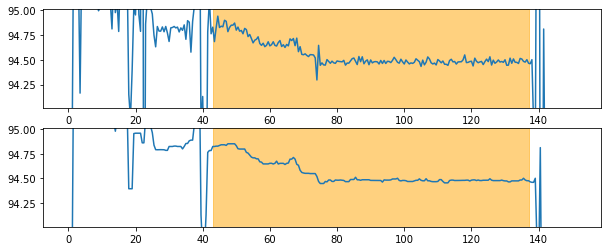

In [66]:
DATA_CAPTURE_ID = 1737
PlotTotalWeightStartEndTimes(DATA_CAPTURE_ID, 2, 2, 5)

In [ ]:
PlotDefecationWeightRadar(1736, 5, .15, 1.8)

In [67]:
res = []
for DATA_CAPTURE_ID in [1736, 1737, 1739, 1740, 1741, 1742, 1743, 1744, 1745]:
    predicted = GetDefecationWeightLoss(DATA_CAPTURE_ID, 5, .15, 1.8)
    actual = ActualWeight[ActualWeight.ID == DATA_CAPTURE_ID].iloc[:, 2].values[0]/1000
    
    start_end_times = GetWeightStartEndTimes(DATA_CAPTURE_ID, 1, 1)
    predicted_total = GetPredictedTotalWeightLoss(DATA_CAPTURE_ID, start_end_times, 23)
    actual_total = ActualWeight[ActualWeight.ID == DATA_CAPTURE_ID]['Total Weight (g)'].values[0]/1000
    res.append([predicted, actual,
                predicted_total - predicted, actual_total - actual,
                predicted_total, actual_total])

User case 1736
Estimated start time: 41.98
Estimated end time: 183.87
Estimated total weight loss: 426.500 g
User case 1737
Estimated start time: 28.31
Estimated end time: 135.53
Estimated total weight loss: 359.000 g
User case 1739
Estimated start time: 20.12
Estimated end time: 119.15
Estimated total weight loss: 539.167 g
User case 1740
Estimated start time: 29.21
Estimated end time: 120.05
Estimated total weight loss: 504.000 g
User case 1741
Estimated start time: 25.57
Estimated end time: 101.85
Estimated total weight loss: 556.500 g
User case 1742
Estimated start time: 28.31
Estimated end time: 110.95
Estimated total weight loss: 620.333 g
User case 1743
Estimated start time: 25.58
Estimated end time: 131.01
Estimated total weight loss: 661.500 g
User case 1744
Estimated start time: 23.76
Estimated end time: 127.36
Estimated total weight loss: 725.167 g
User case 1745
Estimated start time: 24.67
Estimated end time: 113.70
Estimated total weight loss: 557.000 g


In [122]:
resDF = pa.DataFrame(1000 * np.array(res))
resDF.columns = ["Predicted Stool (g)", "Actual Stool (g)",
                 "Predicted Urine (g)", "Actual Urine (g)",
                 "Predicted Total (g)", "Actual Total (g)"]
resDF.index = [1736, 1737, 1739, 1740, 1741, 1742, 1743, 1744, 1745]
resDF.round(1)

,Predicted Stool (g),Actual Stool (g),Predicted Urine (g),Actual Urine (g),Predicted Total (g),Actual Total (g)
1736,193.0,191.2,233.5,197.0,426.5,388.2
1737,214.5,208.4,144.5,200.0,359.0,408.3
1739,307.7,318.6,231.5,197.1,539.2,515.7
1740,255.3,254.9,248.7,200.0,504.0,454.9
1741,317.2,330.7,239.3,200.5,556.5,531.2
1742,380.8,374.7,239.5,200.8,620.3,575.4
1743,440.0,431.0,221.5,197.1,661.5,628.1
1744,503.0,492.3,222.2,198.9,725.2,691.3
1745,299.7,305.8,257.3,198.5,557.0,504.3


In [119]:
def GetErrorRate(nums1, nums2):
    return 100 * (nums1 - nums2) / nums2

In [120]:
errorDF = pa.DataFrame()
#errorDF['Stool Error Rate'] = (resDF['Predicted Stool'] - resDF['Actual Stool']) / resDF['Actual Stool'] * 100
errorDF['Stool Error Rate (%)'] = GetErrorRate(resDF['Predicted Stool (g)'], resDF['Actual Stool (g)'])
errorDF['Urine Error Rate (%)'] = GetErrorRate(resDF['Predicted Urine (g)'], resDF['Actual Urine (g)'])
errorDF['Total Error Rate (%)'] = GetErrorRate(resDF['Predicted Total (g)'], resDF['Actual Total (g)'])
errorDF.loc['Avg'] = (list(errorDF.mean(axis = 0)))
errorDF.round(2)

,Stool Error Rate (%),Urine Error Rate (%),Total Error Rate (%)
1736,1.05,18.88,9.79
1737,2.88,-27.64,-12.25
1739,-3.46,17.26,4.66
1740,0.39,24.00,10.79
1741,-3.94,19.50,4.71
1742,1.60,19.50,7.83
1743,2.09,12.18,5.25
1744,2.03,12.12,4.92
1745,-1.97,29.80,10.32
Avg,0.08,13.96,5.11


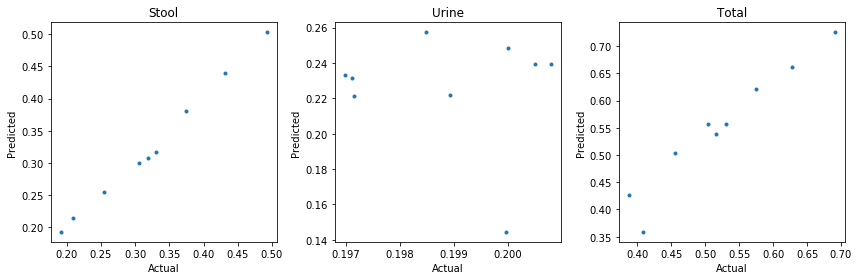

In [69]:
fig, axes = plt.subplots(1, 3, figsize = (12, 4))

for i in range(3):
    predicted_col, actual_col = 2*i, 2*i+1
    axes[i].plot(resDF.iloc[:, actual_col], resDF.iloc[:, predicted_col], '.')
    axes[i].set_xlabel('Actual')
    axes[i].set_ylabel('Predicted')
    axes[i].title.set_text(['Stool', 'Urine', 'Total'][i])
fig.tight_layout()
plt.show()